Step 1:
Clean and prepare your data: There are several entries where values have been deleted to simulate dirty data. Please clean the data with whatever method(s) you believe is best/most suitable. Note that some of the missing values are truly blank (unknown answers) and thus may be impossible to clean; use your discretion.

Step 2:
Build your models: Please build machine learning/statistical models in Python to predict the interest rate assigned to a loan. When writing the code associated with each model, please have the first part produce and save the model, followed by a second part that loads and applies the model.


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

In [56]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="Found unknown categories in columns"
)

In [57]:
MODEL_DIR = "saved_models_loan"
os.makedirs(MODEL_DIR, exist_ok=True)

features
- X1	Interest Rate on the loan
- X2	A unique id for the loan.
- X3	A unique id assigned for the borrower.
- X4	Loan amount requested
- X5	Loan amount funded
- X6	Investor-funded portion of loan
- X7	Number of payments (36 or 60)
- X8	Loan grade
- X9	Loan subgrade
- X10	Employer or job title (self-filled)
- X11	Number of years employed (0 to 10; 10 = 10 or more)
- X12	Home ownership status: RENT, OWN, MORTGAGE, OTHER.
- X13	Annual income of borrower
- X14	Income verified, not verified, or income source was verified
- X15	Date loan was issued
- X16	Reason for loan provided by borrower
- X17	Loan category, as provided by borrower
- X18	Loan title, as provided by borrower
- X19	First 3 numbers of zip code
- X20	State of borrower
- X21	A ratio calculated using the borrower‰Ûªs total monthly debt payments on the total debt obligations, excluding mortgage and the - requested loan, divided by the borrower‰Ûªs self-reported monthly income.
- X22	The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
- X23	Date the borrower's earliest reported credit line was opened
- X24	Number of inquiries by creditors during the past 6 months.
- X25	Number of months since the borrower's last delinquency.
- X26	Number of months since the last public record.
- X27	Number of open credit lines in the borrower's credit file.
- X28	Number of derogatory public records
- X29	Total credit revolving balance
- X30	Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
- X31	The total number of credit lines currently in the borrower's credit file
- X32	The initial listing status of the loan. Possible values are ‰ÛÒ W, F

### step 1

In [58]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [59]:
loan = pd.read_csv('Data for Cleaning & Modeling.csv')

/var/folders/bg/ps2jctlx12jgz_gdlb8g6l4r0000gn/T/ipykernel_2857/1369853827.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  loan = pd.read_csv('Data for Cleaning & Modeling.csv')


In [60]:
loan.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32
0,11.89%,54734.0,80364.0,"$25,000","$25,000","$19,080",36 months,B,B4,NaN,< 1 year,RENT,85000.0,VERIFIED - income,Aug-09,Due to a lack of personal finance education an...,debt_consolidation,Debt consolidation for on-time payer,941xx,CA,19.48,0.0,Feb-94,0.0,NaN,NaN,10.0,0.0,28854.0,52.10%,42.0,f
1,10.71%,55742.0,114426.0,"$7,000","$7,000",$673,36 months,B,B5,CNN,< 1 year,RENT,65000.0,not verified,May-08,Just want to pay off the last bit of credit ca...,credit_card,Credit Card payoff,112xx,NY,14.29,0.0,Oct-00,0.0,NaN,NaN,7.0,0.0,33623.0,76.70%,7.0,f
2,16.99%,57167.0,137225.0,"$25,000","$25,000","$24,725",36 months,D,D3,Web Programmer,1 year,RENT,70000.0,VERIFIED - income,Aug-14,Trying to pay a friend back for apartment brok...,debt_consolidation,mlue,100xx,NY,10.50,0.0,Jun-00,0.0,41.0,NaN,10.0,0.0,19878.0,66.30%,17.0,f
3,13.11%,57245.0,138150.0,"$1,200","$1,200","$1,200",36 months,C,C2,city of beaumont texas,10+ years,OWN,54000.0,not verified,Mar-10,"If funded, I would use this loan consolidate t...",debt_consolidation,zxcvb,777xx,TX,5.47,0.0,Jan-85,0.0,64.0,NaN,5.0,0.0,2584.0,40.40%,31.0,f
4,13.57%,57416.0,139635.0,"$10,800","$10,800","$10,692",36 months,C,C3,State Farm Insurance,6 years,RENT,32000.0,not verified,Nov-09,I currently have a personal loan with Citifina...,debt_consolidation,Nicolechr1978,067xx,CT,11.63,0.0,Dec-96,1.0,58.0,NaN,14.0,0.0,3511.0,25.60%,40.0,f


In [61]:
loan.shape

(400000, 32)

In [62]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   X1      338990 non-null  object 
 1   X2      399999 non-null  float64
 2   X3      399999 non-null  float64
 3   X4      399999 non-null  object 
 4   X5      399999 non-null  object 
 5   X6      399999 non-null  object 
 6   X7      399999 non-null  object 
 7   X8      338730 non-null  object 
 8   X9      338730 non-null  object 
 9   X10     376014 non-null  object 
 10  X11     382462 non-null  object 
 11  X12     338639 non-null  object 
 12  X13     338972 non-null  float64
 13  X14     399999 non-null  object 
 14  X15     399999 non-null  object 
 15  X16     123558 non-null  object 
 16  X17     399999 non-null  object 
 17  X18     399980 non-null  object 
 18  X19     399999 non-null  object 
 19  X20     399999 non-null  object 
 20  X21     399999 non-null  float64
 21  X22     39

In [63]:
loan.describe()

,X2,X3,X13,X21,X22,X24,X25,X26,X27,X28,X29,X31
count,3.999990e+05,3.999990e+05,3.389720e+05,399999.000000,399999.000000,399999.000000,181198.000000,51155.000000,399999.000000,399999.000000,3.999990e+05,399999.000000
mean,9.984493e+06,1.133899e+07,7.316015e+04,17.000786,0.274528,0.817155,34.312117,76.320399,11.117953,0.152285,1.595605e+04,24.983010
std,7.928778e+06,8.663918e+06,5.586770e+04,7.704189,0.778209,1.058746,21.787313,29.804509,4.898569,0.497389,1.952811e+04,11.473478
min,5.473400e+04,7.069900e+04,3.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.000000
25%,3.151742e+06,3.727712e+06,4.500000e+04,11.250000,0.000000,0.000000,16.000000,54.000000,8.000000,0.000000,6.453000e+03,17.000000
50%,8.234778e+06,9.667699e+06,6.300000e+04,16.700000,0.000000,0.000000,31.000000,80.000000,10.000000,0.000000,1.177800e+04,23.000000
75%,1.532960e+07,1.731219e+07,8.820000e+04,22.520000,0.000000,1.000000,50.000000,103.000000,14.000000,0.000000,2.020900e+04,32.000000
max,2.875315e+07,3.127805e+07,7.500000e+06,39.990000,29.000000,8.000000,188.000000,129.000000,76.000000,63.000000,2.568995e+06,121.000000


In [64]:
# data cleaning
def clean_loan_data(loan):

    """
    Clean and preprocess loan data by standardizing formats and data types.
    
    Key operations:
    1. Remove currency symbols and percentage signs
    2. Convert strings to appropriate numeric types
    3. Extract meaningful features from date fields
    4. Handle missing values in categorical variables
    
    Args:
        loan (pd.DataFrame): Raw loan data with formatting issues
        
    Returns:
        pd.DataFrame: Cleaned loan data ready for analysis
    """

    loan = loan.copy()

    # 1. X1: Interest Rate (Target)
    # Convert from percentage string format ("11.89%") to numeric (11.89)
    # This is our target variable for prediction
    if 'X1' in loan.columns:
        original_type = loan['X1'].dtype
        loan['X1'] = loan['X1'].astype(str).str.replace('%', '').str.strip()
        loan['X1'] = pd.to_numeric(loan['X1'], errors='coerce')
        print(f"   ✓ Converted: {original_type} -> {loan['X1'].dtype}")
        if loan['X1'].notna().sum() > 0:
            print(f"   ✓ Range: {loan['X1'].min():.2f}% - {loan['X1'].max():.2f}%")

    # 2. X4, X5, X6
    # Remove currency formatting: "$25,000.00" -> 25000.00
    # These represent the loan amounts in different stages
    for col in ['X4', 'X5', 'X6']:
        if col in loan.columns:
            loan[col] = loan[col].astype(str).str.replace('$', '').str.replace(',', '')
            loan[col] = pd.to_numeric(loan[col], errors='coerce')
            print(f"   ✓ {col}: currency -> numeric")
    
    # 3. X7
    # Extract numeric value from term string: "36 months" -> 36
    # Loan term affects interest rate (36 vs 60 months)
    if 'X7' in loan.columns:
        original_type = loan['X7'].dtype
        loan['X7'] = loan['X7'].astype(str).str.extract(r'(\d+)')[0]
        loan['X7'] = pd.to_numeric(loan['X7'], errors='coerce')
        print(f"   ✓ Converted: {original_type} -> {loan['X7'].dtype}")
        print(f"   ✓ Unique values: {sorted(loan['X7'].dropna().unique())}")
    
    # 4. X8
    # Keep as categorical (A, B, C, D, E, F, G)
    # This is the PRIMARY predictor of interest rate
    if 'X8' in loan.columns:
        print(f"   ✓ Type: {loan['X8'].dtype}, Values: {loan['X8'].unique()[:10]}")
    
    # 5. X13: Annual Income - borrower's yearly income
    if 'X13' in loan.columns:
        loan['X13'] = pd.to_numeric(loan['X13'], errors='coerce')
        print(f"   ✓ Type: {loan['X13'].dtype}")
    
    # 6. X21: DTI Ratio - debt-to-income ratio (key risk indicator)
    if 'X21' in loan.columns:
        loan['X21'] = pd.to_numeric(loan['X21'], errors='coerce')
        print(f"   ✓ Type: {loan['X21'].dtype}")

    # 7. X22: Number of Credit Inquiries (last 6 months)
    if 'X22' in loan.columns:
        loan['X22'] = pd.to_numeric(loan['X22'], errors='coerce')
        print(f"   ✓ Type: {loan['X22'].dtype}")
    
    # 8. X23
    # Transform date string "Feb-94" into years of credit history
    # Older credit history = more established borrower
    if 'X23' in loan.columns:
        # Parse dates
        loan['X23_temp'] = pd.to_datetime(loan['X23'], format='%b-%y', errors='coerce')
        
        # Calculate years from reference year (2015)
        loan['credit_history_years'] = 2015 - loan['X23_temp'].dt.year
        
        # Handle invalid dates (negative or too large)
        loan.loc[loan['credit_history_years'] < 0, 'credit_history_years'] = np.nan
        loan.loc[loan['credit_history_years'] > 100, 'credit_history_years'] = np.nan
        
        # Drop original and temp columns
        loan = loan.drop(['X23', 'X23_temp'], axis=1, errors='ignore')
        print(f"   ✓ X23 -> credit_history_years")
        print(f"   ✓ Range: {loan['credit_history_years'].min():.0f} - {loan['credit_history_years'].max():.0f} years")
    
    # 9. X24, X25, X26, X27, X28, X29
    # Convert various credit-related metrics to numeric
    # X24: Inquiries, X25: Months since delinquency, X26: Months since public record
    # X27: Open credit lines, X28: Public records, X29: Revolving balance
    for col in ['X24', 'X25', 'X26', 'X27', 'X28', 'X29']:
        if col in loan.columns:
            loan[col] = pd.to_numeric(loan[col], errors='coerce')
            print(f"   ✓ {col}: {loan[col].dtype}")
    
    # 10. X30: Debt-to-Income Ratio 
    # Convert percentage string to numeric: "52.10%" -> 52.10
    # High utilization (>70%) indicates potential financial stress
    if 'X30' in loan.columns:
        original_type = loan['X30'].dtype
        loan['X30'] = loan['X30'].astype(str).str.replace('%', '').str.strip()
        loan['X30'] = pd.to_numeric(loan['X30'], errors='coerce')
        print(f"   ✓ Converted: {original_type} -> {loan['X30'].dtype}")
        if loan['X30'].notna().sum() > 0:
            print(f"   ✓ Range: {loan['X30'].min():.2f}% - {loan['X30'].max():.2f}%")
    
    # 11. X31
    # Convert to numeric
    if 'X31' in loan.columns:
        loan['X31'] = pd.to_numeric(loan['X31'], errors='coerce')
        print(f"   ✓ Type: {loan['X31'].dtype}")
    
    # 12. X14: Keep as categorical
    # Keep as categorical, fill missing with 'Unknown'
    # Verified income may affect interest rate
    if 'X14' in loan.columns:
        loan['X14'] = loan['X14'].fillna('Unknown')
        print(f"   ✓ Type: {loan['X14'].dtype}")
    
    # 13. Other categorical columns - fill missing
    # Fill all missing values in categorical columns with 'Missing'
    # This preserves information about missingness as a feature
    categorical_cols = loan.select_dtypes(include=['object']).columns.tolist()
    for col in categorical_cols:
        loan[col] = loan[col].fillna('Missing')
    print(f"   ✓ Filled missing values in {len(categorical_cols)} categorical columns")
    
    print(f"   Final shape: {loan.shape}")
    print(f"   Numerical columns: {len(loan.select_dtypes(include=[np.number]).columns)}")
    print(f"   Categorical columns: {len(loan.select_dtypes(include=['object']).columns)}")
    print("="*80)
    
    return loan

In [65]:
loan = clean_loan_data(loan)

   ✓ Converted: object -> float64
   ✓ Range: 5.42% - 26.06%
   ✓ X4: currency -> numeric
   ✓ X5: currency -> numeric
   ✓ X6: currency -> numeric
   ✓ Converted: object -> float64
   ✓ Unique values: [np.float64(36.0), np.float64(60.0)]
   ✓ Type: object, Values: ['B' 'D' 'C' 'A' 'E' 'F' nan 'G']
   ✓ Type: float64
   ✓ Type: float64
   ✓ Type: float64
   ✓ X23 -> credit_history_years
   ✓ Range: 4 - 46 years
   ✓ X24: float64
   ✓ X25: float64
   ✓ X26: float64
   ✓ X27: float64
   ✓ X28: float64
   ✓ X29: float64
   ✓ Converted: object -> float64
   ✓ Range: 0.00% - 892.30%
   ✓ Type: float64
   ✓ Type: object
   ✓ Filled missing values in 13 categorical columns
   Final shape: (400000, 32)
   Numerical columns: 19
   Categorical columns: 13



Basic Statistics:
count    338990.000000
mean         13.946271
std           4.377951
min           5.420000
25%          10.990000
50%          13.680000
75%          16.780000
max          26.060000
Name: X1, dtype: float64
Mean: 13.95%
Median: 13.68%
Std: 4.38%


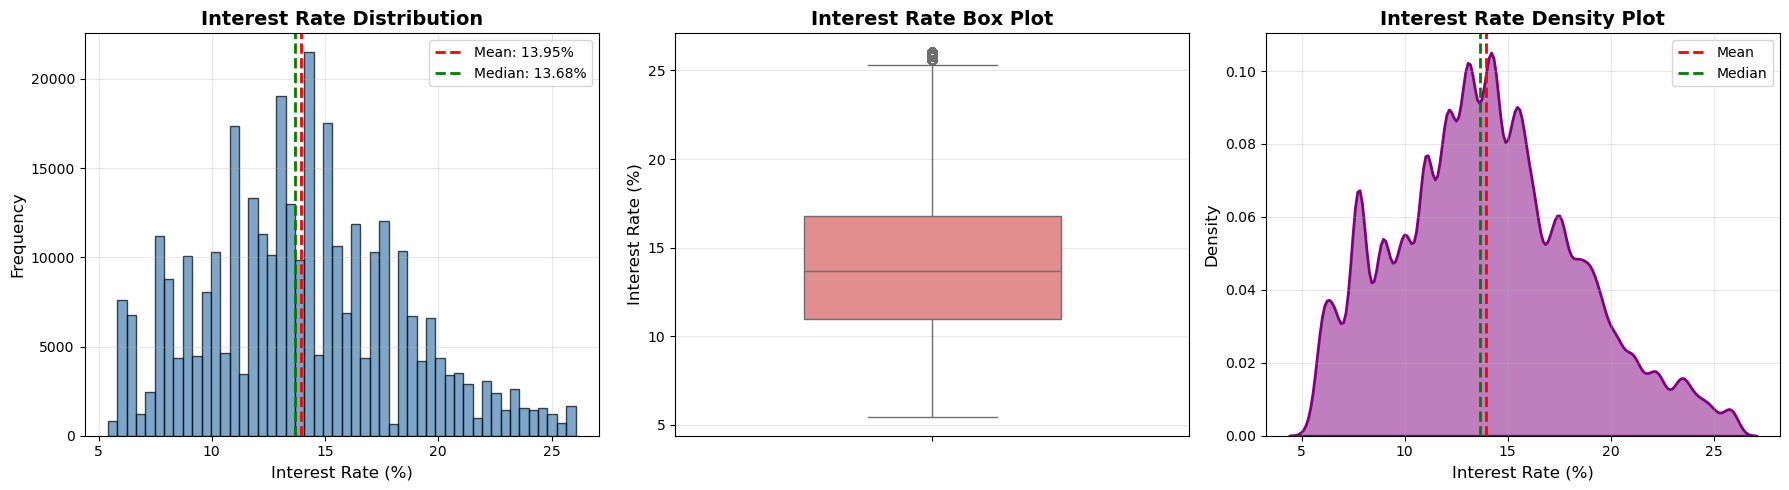

In [66]:
#TARGET VARIABLE ANALYSIS: Interest Rate (X1)")

print("\nBasic Statistics:")
print(loan['X1'].describe())
print(f"Mean: {loan['X1'].mean():.2f}%")
print(f"Median: {loan['X1'].median():.2f}%")
print(f"Std: {loan['X1'].std():.2f}%")

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
loan['X1'].hist(bins=50, ax=axes[0], edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_title('Interest Rate Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Interest Rate (%)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].axvline(loan['X1'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {loan["X1"].mean():.2f}%')
axes[0].axvline(loan['X1'].median(), color='green', linestyle='--', linewidth=2,
                label=f'Median: {loan["X1"].median():.2f}%')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Box plot
sns.boxplot(y=loan['X1'], ax=axes[1], color='lightcoral', width=0.5)
axes[1].set_title('Interest Rate Box Plot', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Interest Rate (%)', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

# KDE plot
sns.kdeplot(loan['X1'], ax=axes[2], fill=True, color='purple', alpha=0.5, linewidth=2)
axes[2].set_title('Interest Rate Density Plot', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Interest Rate (%)', fontsize=12)
axes[2].set_ylabel('Density', fontsize=12)
axes[2].axvline(loan['X1'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[2].axvline(loan['X1'].median(), color='green', linestyle='--', linewidth=2, label='Median')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The target variable (Interest Rate) exhibits an approximately normal distribution with a slight positive (right) skew. The mean (13.95%) is slightly higher than the median (13.68%), indicating the presence of some higher interest rate values pulling the distribution to the right. Most loans fall within the interquartile range, suggesting moderate variability with a few high-end outliers.


Interest Rate Statistics by Grade:
          mean  median   std  count    min    max
X8                                               
A         7.58    7.69  0.99  45525   5.42   9.63
B        11.61   11.67  1.27  86121   6.00  14.09
C        14.79   14.64  1.16  76446   6.00  17.27
D        17.72   17.77  1.36  46984   6.00  20.31
E        20.66   20.99  1.55  21628   6.00  23.40
F        23.61   23.76  1.54   8395   6.00  25.57
G        25.14   25.80  1.49   2024  17.34  26.06
Missing  13.95   13.92  4.38  51867   5.42  26.06

Found 51867 loans with Missing grade
   Average rate for Missing: 13.95%
   These will need to be handled during preprocessing!


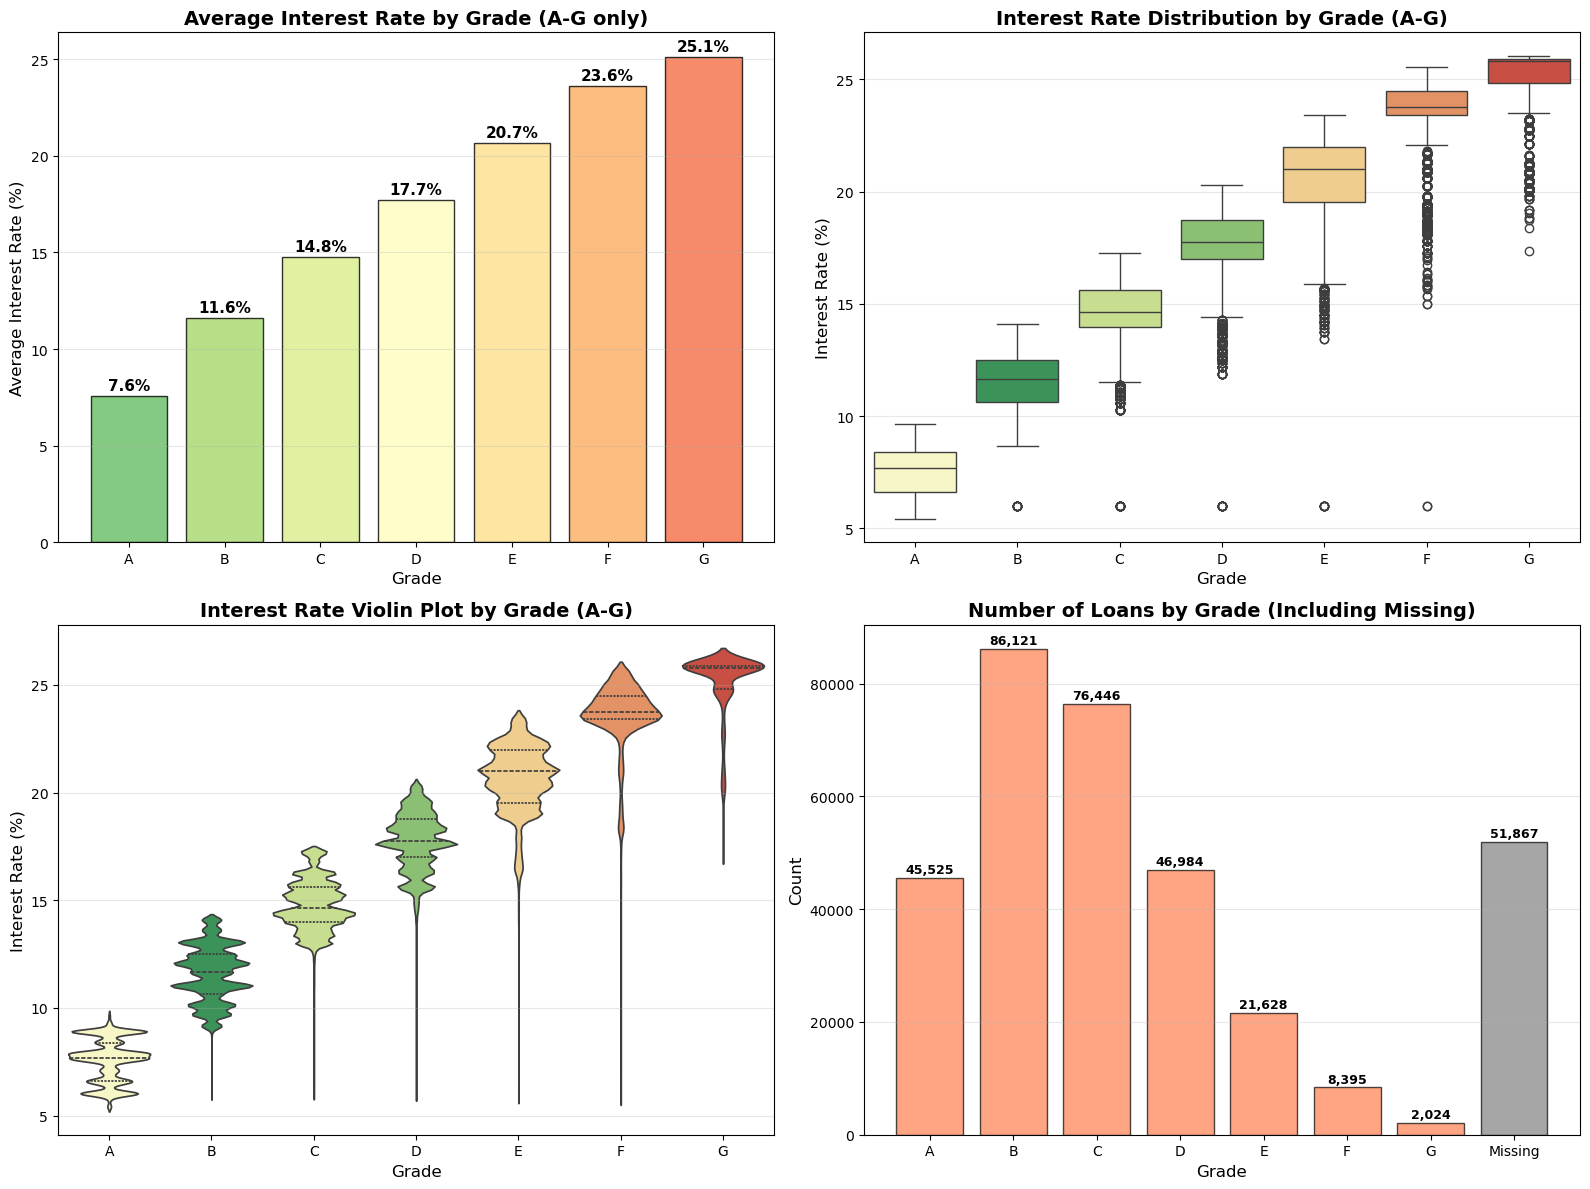


CRITICAL FINDING: Grade is the strongest predictor of interest rate!
Grade A avg: 7.58% vs Grade G avg: 25.14%
Clear monotonic relationship: worse grade → higher rate
Total valid grades (A-G): 338,730 loans (84.7%)
Missing grades: 51,867 loans (13.0%)


In [67]:
# LOAN GRADE (X8) vs INTEREST RATE - PRIMARY PREDICTOR")

grade_stats = loan.groupby('X8')['X1'].agg(['mean', 'median', 'std', 'count', 'min', 'max']).round(2)
print("\nInterest Rate Statistics by Grade:")
print(grade_stats)

#chicking missing value
if 'Missing' in grade_stats.index:
    print(f"\nFound {grade_stats.loc['Missing', 'count']:.0f} loans with Missing grade")
    print(f"   Average rate for Missing: {grade_stats.loc['Missing', 'mean']:.2f}%")
    print(f"   These will need to be handled during preprocessing!")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

valid_grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
df_valid = loan[loan['X8'].isin(valid_grades)].copy()
grade_stats_valid = df_valid.groupby('X8')['X1'].agg(['mean', 'count']).round(2)

# 1) Bar plot - Average Interest Rate by Grade (Valid only)
grade_means = grade_stats_valid['mean'].sort_index()
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(grade_means)))
bars = axes[0, 0].bar(range(len(grade_means)), grade_means, color=colors, alpha=0.8, edgecolor='black')
axes[0, 0].set_title('Average Interest Rate by Grade (A-G only)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Grade', fontsize=12)
axes[0, 0].set_ylabel('Average Interest Rate (%)', fontsize=12)
axes[0, 0].set_xticks(range(len(grade_means)))
axes[0, 0].set_xticklabels(grade_means.index)
axes[0, 0].grid(True, alpha=0.3, axis='y')

for i, (bar, val) in enumerate(zip(bars, grade_means)):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, val + 0.3, 
                    f'{val:.1f}%', ha='center', fontweight='bold', fontsize=11)

# Box plot - Distribution by Grade (Valid only)
sns.boxplot(data=df_valid, x='X8', y='X1', ax=axes[0, 1], 
            order=valid_grades, hue='X8', palette='RdYlGn_r', legend=False)
axes[0, 1].set_title('Interest Rate Distribution by Grade (A-G)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Grade', fontsize=12)
axes[0, 1].set_ylabel('Interest Rate (%)', fontsize=12)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Violin plot - Detailed distribution (Valid only)
sns.violinplot(data=df_valid, x='X8', y='X1', ax=axes[1, 0], 
               order=valid_grades, hue='X8', palette='RdYlGn_r', 
               inner='quartile', legend=False)
axes[1, 0].set_title('Interest Rate Violin Plot by Grade (A-G)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Grade', fontsize=12)
axes[1, 0].set_ylabel('Interest Rate (%)', fontsize=12)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Count plot - Sample size by Grade (ALL including Missing)
grade_counts = grade_stats['count'].sort_index()
colors_all = ['coral' if idx in valid_grades else 'gray' for idx in grade_counts.index]
bars = axes[1, 1].bar(range(len(grade_counts)), grade_counts, color=colors_all, 
                      alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Number of Loans by Grade (Including Missing)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Grade', fontsize=12)
axes[1, 1].set_ylabel('Count', fontsize=12)
axes[1, 1].set_xticks(range(len(grade_counts)))
axes[1, 1].set_xticklabels(grade_counts.index, rotation=0)
axes[1, 1].grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, grade_counts):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, val + max(grade_counts)*0.01,
                    f'{int(val):,}', ha='center', fontweight='bold', fontsize=9, rotation=0)

plt.tight_layout()
plt.show()

print("\nCRITICAL FINDING: Grade is the strongest predictor of interest rate!")
if 'A' in grade_stats_valid.index and len(grade_stats_valid) > 0:
    print(f"Grade A avg: {grade_stats_valid.loc['A', 'mean']:.2f}% vs Grade {valid_grades[-1]} avg: {grade_stats_valid.loc[valid_grades[-1], 'mean']:.2f}%")
print(f"Clear monotonic relationship: worse grade → higher rate")
print(f"Total valid grades (A-G): {df_valid.shape[0]:,} loans ({df_valid.shape[0]/len(loan)*100:.1f}%)")
if 'Missing' in grade_stats.index:
    print(f"Missing grades: {int(grade_stats.loc['Missing', 'count']):,} loans ({grade_stats.loc['Missing', 'count']/len(loan)*100:.1f}%)")


Loan grade (X8) shows a clear and strong monotonic relationship with interest rate, confirming it as the primary predictor.
The average interest rate increases consistently from Grade A (7.58%) to Grade G (25.14%), representing a substantial spread of over 17 percentage points.
Both the boxplot and violin plot demonstrate well-separated distributions across grades, with minimal overlap between adjacent categories.
This indicates that loan grade effectively captures borrower risk and is a dominant driver of pricing.

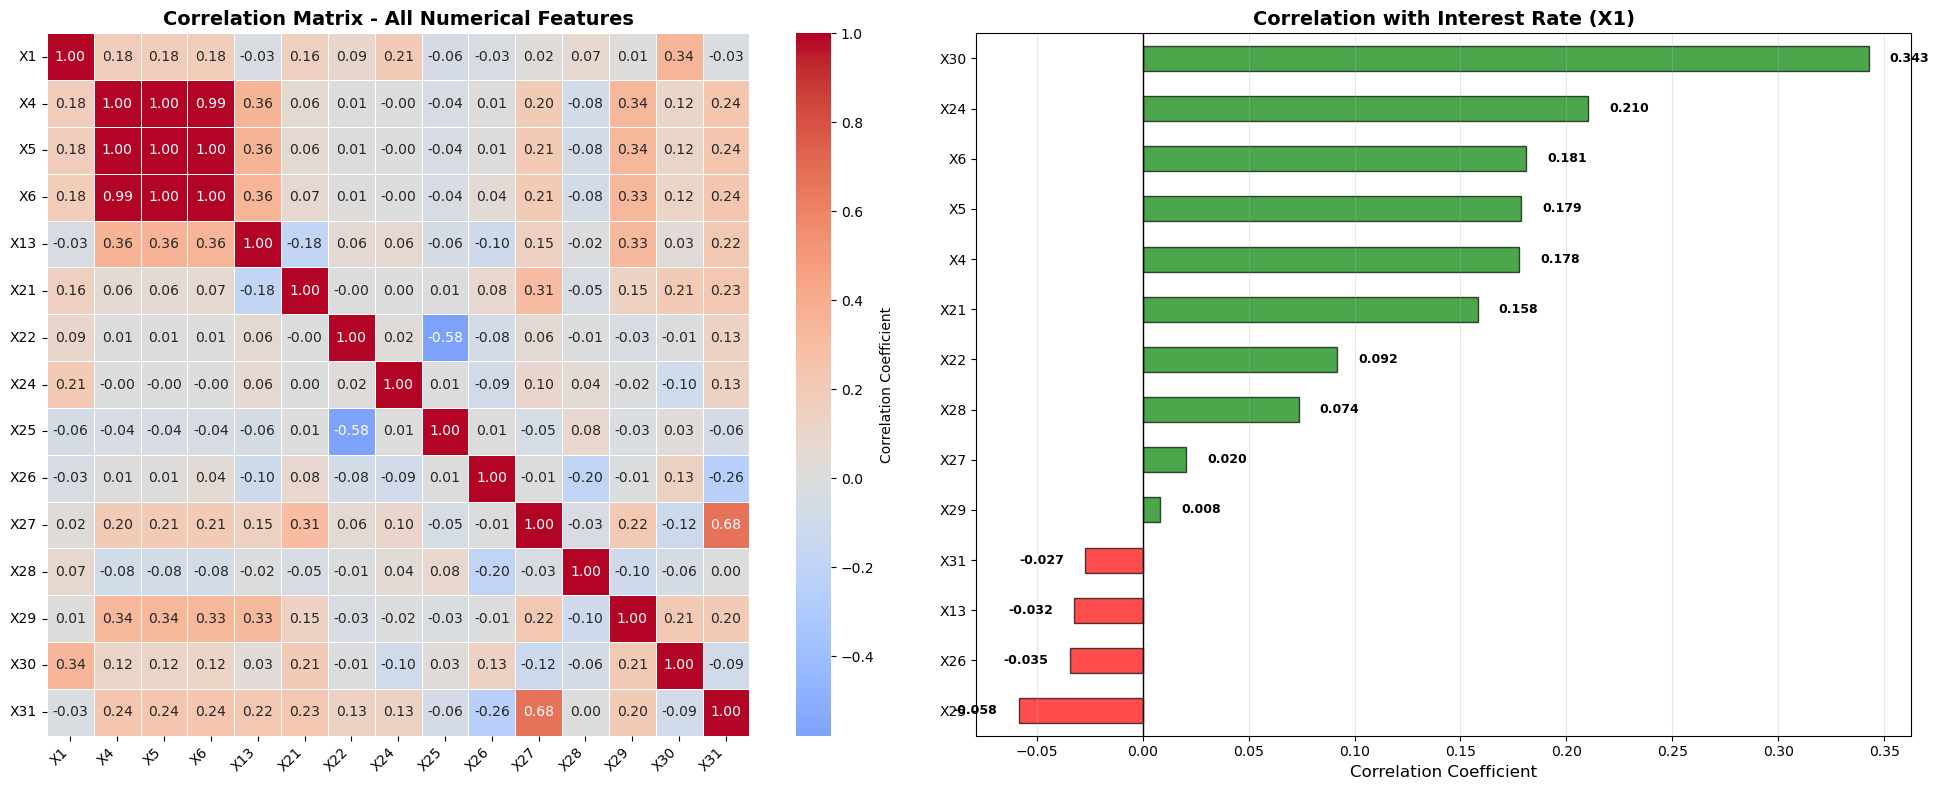


Top 5 POSITIVE Correlations with Interest Rate:
X4     0.177732
X5     0.178727
X6     0.181031
X24    0.210398
X30    0.342609
Name: X1, dtype: float64

Top 5 NEGATIVE Correlations with Interest Rate:
X25   -0.058441
X26   -0.034513
X13   -0.032207
X31   -0.027147
X29    0.008171
Name: X1, dtype: float64


In [68]:
#CORRELATION ANALYSIS - NUMERICAL FEATURES

numerical_cols = ['X1', 'X4', 'X5', 'X6', 'X13', 'X21', 'X22', 'X24', 
                  'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31']
numerical_cols = [col for col in numerical_cols if col in loan.columns]

correlation = loan[numerical_cols].corr()

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Full correlation heatmap
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=axes[0], square=True, linewidths=0.5,
            cbar_kws={'label': 'Correlation Coefficient'})
axes[0].set_title('Correlation Matrix - All Numerical Features', fontsize=14, fontweight='bold')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

# Correlation with Target (X1) - Bar plot
target_corr = correlation['X1'].drop('X1').sort_values(ascending=True)
colors = ['green' if x > 0 else 'red' for x in target_corr]
target_corr.plot(kind='barh', ax=axes[1], color=colors, alpha=0.7, edgecolor='black')
axes[1].set_title('Correlation with Interest Rate (X1)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Correlation Coefficient', fontsize=12)
axes[1].axvline(0, color='black', linewidth=1)
axes[1].grid(True, alpha=0.3, axis='x')

for i, (idx, val) in enumerate(target_corr.items()):
    axes[1].text(val + 0.01 if val > 0 else val - 0.01, i, f'{val:.3f}', 
                va='center', ha='left' if val > 0 else 'right', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Top correlations
print("\nTop 5 POSITIVE Correlations with Interest Rate:")
print(target_corr.tail(5))
print("\nTop 5 NEGATIVE Correlations with Interest Rate:")
print(target_corr.head(5))


No numerical feature shows a strong linear correlation with interest rate. X30 has the highest correlation (r = 0.343), while most other variables exhibit weak to moderate relationships. Significant multicollinearity is observed among X4, X5, and X6, which should be addressed in modeling.

In [69]:
# Missing value
missing = loan.isnull().sum()
missing_feature = missing[missing > 0].index.tolist()  
missing_pct = (missing / len(loan)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))

                      Missing Count  Percentage
X26                          348845    87.21125
X25                          218802    54.70050
X13                           61028    15.25700
X1                            61010    15.25250
credit_history_years            991     0.24775
X30                             267     0.06675
X6                                1     0.00025
X7                                1     0.00025
X5                                1     0.00025
X21                               1     0.00025
X2                                1     0.00025
X24                               1     0.00025
X4                                1     0.00025
X3                                1     0.00025
X27                               1     0.00025
X28                               1     0.00025
X29                               1     0.00025
X31                               1     0.00025
X22                               1     0.00025


In [70]:
#numerical variables
numerical_features = loan.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumerical columns ({len(numerical_features)}): {numerical_features}")
print("\nStatistical Summary:")
print(loan[numerical_features].describe().T.round(2))


Numerical columns (19): ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X13', 'X21', 'X22', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'credit_history_years']

Statistical Summary:
                         count         mean         std       min         25%  \
X1                    338990.0        13.95        4.38      5.42       10.99   
X2                    399999.0   9984493.12  7928778.25  54734.00  3151742.50   
X3                    399999.0  11338986.00  8663918.27  70699.00  3727711.50   
X4                    399999.0     14274.06     8251.45    500.00     8000.00   
X5                    399999.0     14245.76     8236.94    500.00     8000.00   
X6                    399999.0     14182.98     8250.99      0.00     8000.00   
X7                    399999.0        42.46       10.64     36.00       36.00   
X13                   338972.0     73160.15    55867.70   3000.00    45000.00   
X21                   399999.0        17.00        7.70      0.00       11.25   

In [71]:
#distribution of numerical variables

print("\nSkewness:")
skew = loan[numerical_features].skew().sort_values(ascending=False)
print(skew.round(2))


Skewness:
X13                     33.53
X29                     22.48
X28                     17.27
X22                      5.39
X24                      1.50
X27                      1.13
X7                       1.04
credit_history_years     0.95
X31                      0.78
X5                       0.74
X6                       0.74
X4                       0.74
X2                       0.67
X3                       0.57
X25                      0.46
X1                       0.31
X21                      0.16
X30                     -0.17
X26                     -0.50
dtype: float64


In [72]:
#list of categorical variables

categorical_features = loan.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns ({len(categorical_features)}): {categorical_features}")


Categorical columns (13): ['X8', 'X9', 'X10', 'X11', 'X12', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X32']


In [73]:
#cardinality of categorical variables

if len(categorical_features) > 0:
    card = pd.DataFrame({
        'Column': categorical_features,
        'Unique': [loan[c].nunique() for c in categorical_features],
        'Top_5': [loan[c].value_counts().head(5).index.tolist() for c in categorical_features]
    })
    print("\n" + card.to_string(index=False))


Column  Unique                                                                                                                                          Top_5
    X8       8                                                                                                                          [B, C, Missing, D, A]
    X9      36                                                                                                                      [Missing, B3, B4, B2, C1]
   X10  187822                                                                                              [Missing, Teacher, Manager, Registered Nurse, RN]
   X11      12                                                                                               [10+ years, 2 years, 3 years, < 1 year, 5 years]
   X12       7                                                                                                          [MORTGAGE, RENT, Missing, OWN, OTHER]
   X14       4                                     

In [74]:
# Outlier
outlier_info = []
for col in numerical_features:
    if col not in ['X1', 'X2', 'X3']:
        Q1, Q3 = loan[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        n_out = ((loan[col] < lower) | (loan[col] > upper)).sum()
        if n_out > 0:
            outlier_info.append({
                'Column': col,
                'Count': n_out,
                'Percent': f"{n_out/len(loan)*100:.1f}%"
            })

if outlier_info:
    print("\nOutliers found:")
    print(pd.DataFrame(outlier_info).to_string(index=False))


Outliers found:
              Column  Count Percent
                 X13  14285    3.6%
                 X21    124    0.0%
                 X22  69466   17.4%
                 X24  32386    8.1%
                 X25     70    0.0%
                 X27   8153    2.0%
                 X28  50485   12.6%
                 X29  18656    4.7%
                 X30     12    0.0%
                 X31   7099    1.8%
credit_history_years  13103    3.3%


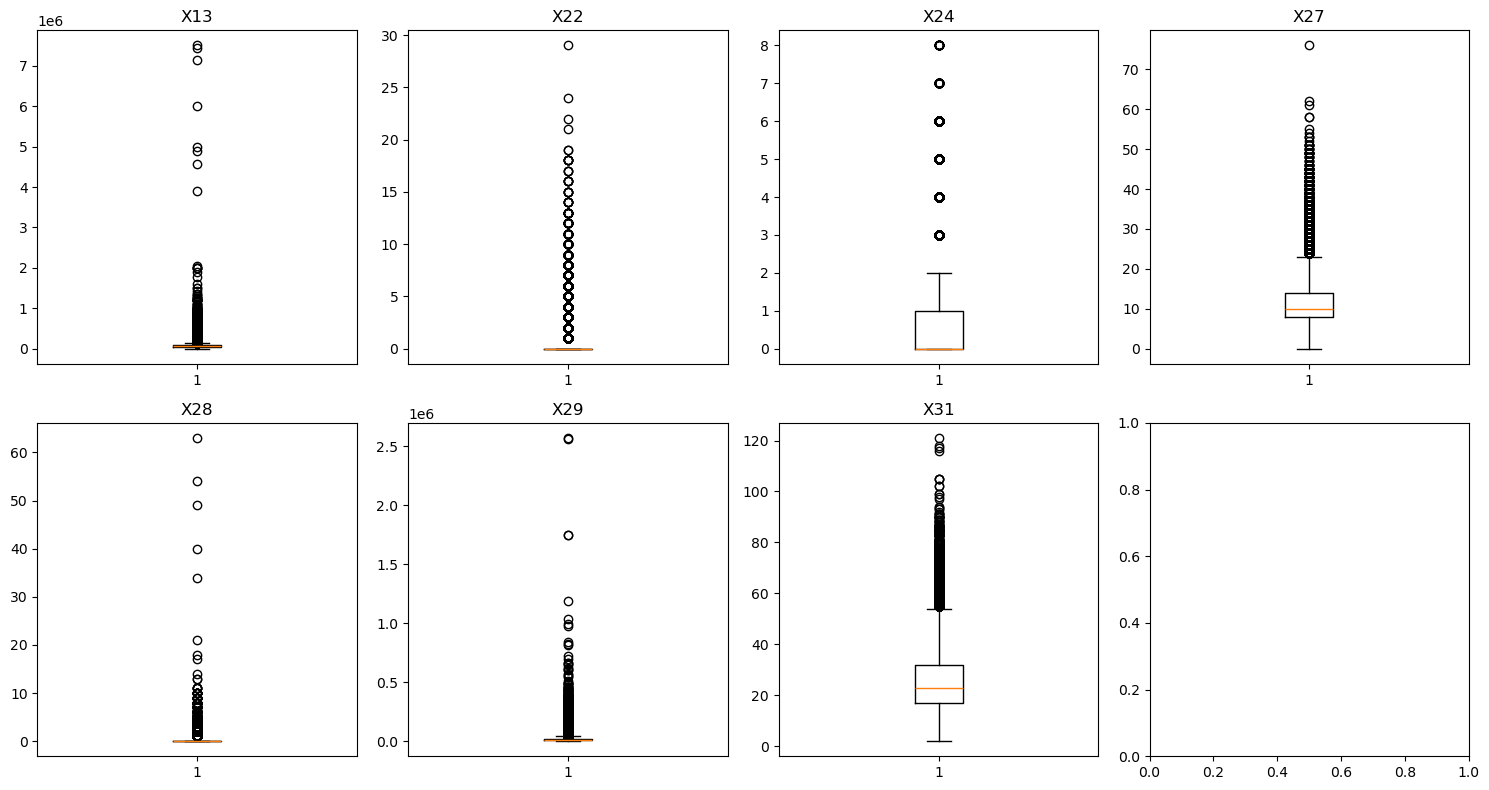

In [75]:
outlier_cols = ['X13', 'X22', 'X24', 'X27', 'X28', 'X29', 'X31']

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
for idx, col in enumerate(outlier_cols):
    ax = axes[idx // 4, idx % 4]
    ax.boxplot(loan[col].dropna())
    ax.set_title(col)
plt.tight_layout()
plt.show()

### Target variable Analysis

In [76]:
# Correlation with Target
if 'X1' in numerical_features:
    print("\nCorrelation with Interest Rate (X1):")
    corr = loan[numerical_features].corr()['X1'].sort_values(ascending=False)
    
    # except X1
    corr = corr.drop('X1', errors='ignore')
    
    print(corr.round(3))
    
    print("\nStrong correlations (|r| > 0.3):")
    strong = corr[abs(corr) > 0.3]
    if len(strong) > 0:  
        print(strong.round(3))
    else:
        print("No strong correlations found")


Correlation with Interest Rate (X1):
X7                      0.456
X30                     0.343
X24                     0.210
X6                      0.181
X5                      0.179
X4                      0.178
X21                     0.158
X22                     0.092
X28                     0.074
X3                      0.035
X2                      0.034
X27                     0.020
X29                     0.008
X31                    -0.027
X13                    -0.032
X26                    -0.035
X25                    -0.058
credit_history_years   -0.084
Name: X1, dtype: float64

Strong correlations (|r| > 0.3):
X7     0.456
X30    0.343
Name: X1, dtype: float64


### Missing Values

In [77]:
loan.isnull().sum()[loan.isnull().sum() > 0]

X1                       61010
X2                           1
X3                           1
X4                           1
X5                           1
X6                           1
X7                           1
X13                      61028
X21                          1
X22                          1
X24                          1
X25                     218802
X26                     348845
X27                          1
X28                          1
X29                          1
X30                        267
X31                          1
credit_history_years       991
dtype: int64

In [78]:
#no need columns
loan = loan.drop(columns=["X2", "X3"])

In [79]:
y = loan['X1'].copy()
X = loan.drop(['X1'], axis=1)

print(f"  Original shape: {loan.shape}")
print(f"  Features (X): {X.shape}")
print(f"  Target (y): {y.shape}")

  Original shape: (400000, 30)
  Features (X): (400000, 29)
  Target (y): (400000,)


In [80]:
# # Categorical: fill with 'Missing'
# cat_cols_in_X = [c for c in categorical_features if c in X.columns]
# for col in cat_cols_in_X:
#     X[col] = X[col].fillna('Missing')

In [81]:
# # Numerical: median imputation
# num_cols_in_X = [c for c in numerical_features if c in X.columns and c != 'X1']
# imputer = SimpleImputer(strategy='median')
# X[num_cols_in_X] = imputer.fit_transform(X[num_cols_in_X])

# print(f"  Remaining NaN: {X.isnull().sum().sum()}")

In [82]:
print(X.isnull().sum()[X.isnull().sum() > 0])

X4                           1
X5                           1
X6                           1
X7                           1
X13                      61028
X21                          1
X22                          1
X24                          1
X25                     218802
X26                     348845
X27                          1
X28                          1
X29                          1
X30                        267
X31                          1
credit_history_years       991
dtype: int64


### Handling imbalanced datasets

In [83]:
print("\nRegression task - checking target distribution:")
print(f"  Mean: {y.mean():.2f}%")
print(f"  Median: {y.median():.2f}%")
print(f"  Std: {y.std():.2f}%")
print(f"  Range: {y.min():.2f}% - {y.max():.2f}%")
print(f"  Skewness: {y.skew():.2f}")

bins = [0, 5, 10, 15, 20, 25, 30, 100]
labels = ['0-5%', '5-10%', '10-15%', '15-20%', '20-25%', '25-30%', '30%+']
print("\nDistribution across bins:")
print(pd.cut(y, bins=bins, labels=labels).value_counts().sort_index())


Regression task - checking target distribution:
  Mean: 13.95%
  Median: 13.68%
  Std: 4.38%
  Range: 5.42% - 26.06%
  Skewness: 0.31

Distribution across bins:
X1
0-5%           0
5-10%      67582
10-15%    142886
15-20%     97582
20-25%     28591
25-30%      2349
30%+           0
Name: count, dtype: int64


In [84]:
# # processing outlier
# # Capping outliers instead of removing them to preserve all data points while limiting extreme values' influence on the model
# for col in num_cols_in_X:
#     Q1, Q3 = X[col].quantile([0.25, 0.75])
#     IQR = Q3 - Q1
#     lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
#     X[col] = X[col].clip(lower, upper)  

### Train test

In [85]:
#Split Before encoding/scaling
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train: {X_train.shape}, Val: {X_val.shape}")

Train: (320000, 29), Val: (80000, 29)


In [86]:
# Categorical: fill with 'Missing'
cat_cols_in_X = [c for c in categorical_features if c in X_train.columns]

print(f"Categorical columns: {len(cat_cols_in_X)}")
print(f"Train NaN before: {X_train[cat_cols_in_X].isnull().sum().sum()}")
print(f"Val NaN before: {X_val[cat_cols_in_X].isnull().sum().sum()}")

# Train: fillna
for col in cat_cols_in_X:
    X_train[col] = X_train[col].fillna('Missing')

# Val: fillna
for col in cat_cols_in_X:
    X_val[col] = X_val[col].fillna('Missing')

print(f"Train NaN after: {X_train[cat_cols_in_X].isnull().sum().sum()}")
print(f"Val NaN after: {X_val[cat_cols_in_X].isnull().sum().sum()}")

Categorical columns: 13
Train NaN before: 0
Val NaN before: 0
Train NaN after: 0
Val NaN after: 0


In [87]:
# Numerical: median imputation
num_cols_in_X = [c for c in numerical_features if c in X_train.columns and c != 'X1']

print(f"Numerical columns: {len(num_cols_in_X)}")
print(f"Train NaN before: {X_train[num_cols_in_X].isnull().sum().sum()}")
print(f"Val NaN before: {X_val[num_cols_in_X].isnull().sum().sum()}")

imputer = SimpleImputer(strategy='median')
X_train[num_cols_in_X] = imputer.fit_transform(X_train[num_cols_in_X])

X_val[num_cols_in_X] = imputer.transform(X_val[num_cols_in_X])

print(f"Train NaN after: {X_train[num_cols_in_X].isnull().sum().sum()}")
print(f"Val NaN after: {X_val[num_cols_in_X].isnull().sum().sum()}")

Numerical columns: 16
Train NaN before: 504180
Val NaN before: 125764
Train NaN after: 0
Val NaN after: 0


In [88]:
#outlier processing - train only
outlier_bounds = {}

for col in num_cols_in_X:
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    
    outlier_bounds[col] = {'lower': lower, 'upper': upper}
    
    X_train[col] = X_train[col].clip(lower, upper)
    print(f"  {col}: [{lower:.2f}, {upper:.2f}]")

print("\nApplying outlier bounds to validation set")
for col in num_cols_in_X:
    lower = outlier_bounds[col]['lower']
    upper = outlier_bounds[col]['upper']
    X_val[col] = X_val[col].clip(lower, upper)


  X4: [-10000.00, 38000.00]
  X5: [-10000.00, 38000.00]
  X6: [-9850.00, 37750.00]
  X7: [0.00, 96.00]
  X13: [-981.88, 131789.12]
  X21: [-5.68, 39.44]
  X22: [0.00, 0.00]
  X24: [-1.50, 2.50]
  X25: [31.00, 31.00]
  X26: [80.00, 80.00]
  X27: [-1.00, 23.00]
  X28: [0.00, 0.00]
  X29: [-14198.88, 40854.12]
  X30: [-13.45, 127.75]
  X31: [-5.50, 54.50]
  credit_history_years: [1.00, 33.00]

Applying outlier bounds to validation set


In [89]:
print(f"y_train NaN: {y_train.isnull().sum()}")
print(f"y_val NaN: {y_val.isnull().sum()}")

# Remove NaN at y_train
if y_train.isnull().sum() > 0:
    mask = y_train.notna()
    X_train = X_train[mask]
    y_train = y_train[mask]
    print(f"Removed {(~mask).sum()} rows from train")

# Remove NaN at y_val
if y_val.isnull().sum() > 0:
    mask = y_val.notna()
    X_val = X_val[mask]
    y_val = y_val[mask]
    print(f"Removed {(~mask).sum()} rows from val")

print(f"\nFinal shapes:")
print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Val: X={X_val.shape}, y={y_val.shape}")



y_train NaN: 48855
y_val NaN: 12155
Removed 48855 rows from train
Removed 12155 rows from val

Final shapes:
Train: X=(271145, 29), y=(271145,)
Val: X=(67845, 29), y=(67845,)


In [90]:
import time
start_time = time.time()

label_mappings = {}

cat_cols_in_X = [c for c in categorical_features if c in X_train.columns]

print(f"\nEncoding {len(cat_cols_in_X)} categorical columns...")

for col in cat_cols_in_X:
    unique_vals = X_train[col].unique()
    
    mapping = {val: idx for idx, val in enumerate(unique_vals)}
    
    if 'Missing' not in mapping:
        mapping['Missing'] = len(mapping)
    
    X_train[col] = X_train[col].map(mapping)
    
    X_val[col] = X_val[col].map(mapping).fillna(mapping['Missing'])
    
    label_mappings[col] = mapping
    
    print(f"  {col}: {len(mapping)} categories")

encoding_time = time.time() - start_time
print(f"{len(label_mappings)} columns encoded")


Encoding 13 categorical columns...
  X8: 8 categories
  X9: 36 categories
  X10: 135030 categories
  X11: 12 categories
  X12: 7 categories
  X14: 5 categories
  X15: 92 categories
  X16: 83375 categories
  X17: 15 categories
  X18: 44265 categories
  X19: 869 categories
  X20: 51 categories
  X32: 3 categories
13 columns encoded


In [91]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)     
X_val_scaled = scaler.transform(X_val)             

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)

In [92]:
models = {
    'Random Forest': RandomForestRegressor(
        n_estimators=100, max_depth=15, min_samples_split=10,
        random_state=42, n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=100, learning_rate=0.1, max_depth=5,
        random_state=42
    ),
    'Ridge': Ridge(alpha=10.0),
    'Lasso': Lasso(alpha=0.1, max_iter=5000),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=5000)
}

results = {}
best_val_rmse = float('inf')
best_model = None
best_model_name = None

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    if 'Forest' in name or 'Boosting' in name:
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)
        uses_scaling = False
    else:
        model.fit(X_train_scaled, y_train)
        train_pred = model.predict(X_train_scaled)
        val_pred = model.predict(X_val_scaled)
        uses_scaling = True
    
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    train_r2 = r2_score(y_train, train_pred)
    val_r2 = r2_score(y_val, val_pred)
    val_mae = mean_absolute_error(y_val, val_pred)
    
    results[name] = {
        'model': model,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'val_mae': val_mae,
        'uses_scaling': uses_scaling
    }
    
    print(f"  Train RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")
    print(f"  Val   RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}, MAE: {val_mae:.4f}")
    
    model_filename = os.path.join(MODEL_DIR, f"{name}.pkl")
    joblib.dump(model, model_filename)
    print(f"  Model saved: {model_filename}")
    
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_model = model
        best_model_name = name

# Save scaler (if used by best model)
if results[best_model_name]['uses_scaling']:
    scaler_filename = os.path.join(MODEL_DIR, "scaler.pkl")
    joblib.dump(scaler, scaler_filename)
    print(f"\nScaler saved: {scaler_filename}")

# Save best model info
best_model_info = {
    'name': best_model_name,
    'val_rmse': best_val_rmse,
    'val_r2': results[best_model_name]['val_r2'],
    'uses_scaling': results[best_model_name]['uses_scaling']
}

info_filename = os.path.join(MODEL_DIR, "best_model_info.pkl")
joblib.dump(best_model_info, info_filename)
print(f"Best model info saved: {info_filename}")

print(f"\nAll Models Performance:")
print(f"{'Model':<20} {'Train RMSE':<12} {'Val RMSE':<12} {'Val R²':<10} {'Val MAE':<10}")
print('-'*80)
for name, res in results.items():
    print(f"{name:<20} {res['train_rmse']:<12.4f} {res['val_rmse']:<12.4f} {res['val_r2']:<10.4f} {res['val_mae']:<10.4f}")

print(f"BEST MODEL: {best_model_name}")
print(f"     Validation RMSE: {best_val_rmse:.4f}")
print(f"     Validation R²: {results[best_model_name]['val_r2']:.4f}")
print(f"     Uses Scaling: {results[best_model_name]['uses_scaling']}")
print(f"{'='*80}")

print(f"\nAll models saved in: {MODEL_DIR}/")
print(f"  Files saved:")
for filename in os.listdir(MODEL_DIR):
    print(f"    - {filename}")


Training Random Forest...
  Train RMSE: 1.1520, R²: 0.9308
  Val   RMSE: 1.2741, R²: 0.9149, MAE: 0.5042
  Model saved: saved_models_loan/Random Forest.pkl

Training Gradient Boosting...
  Train RMSE: 1.2989, R²: 0.9121
  Val   RMSE: 1.2958, R²: 0.9120, MAE: 0.6878
  Model saved: saved_models_loan/Gradient Boosting.pkl

Training Ridge...
  Train RMSE: 3.0792, R²: 0.5059
  Val   RMSE: 3.0933, R²: 0.4984, MAE: 2.4584
  Model saved: saved_models_loan/Ridge.pkl

Training Lasso...
  Train RMSE: 3.1203, R²: 0.4926
  Val   RMSE: 3.1272, R²: 0.4873, MAE: 2.4930
  Model saved: saved_models_loan/Lasso.pkl

Training ElasticNet...
  Train RMSE: 3.1019, R²: 0.4986
  Val   RMSE: 3.1124, R²: 0.4922, MAE: 2.4763
  Model saved: saved_models_loan/ElasticNet.pkl
Best model info saved: saved_models_loan/best_model_info.pkl

All Models Performance:
Model                Train RMSE   Val RMSE     Val R²     Val MAE   
--------------------------------------------------------------------------------
Random Fo

#### Target Variable Analysis: Interest Rate (X1)

The target variable (Interest Rate) shows an approximately normal distribution with a slight right skew. The mean (13.95%) is a bit higher than the median (13.68%), which means there are some loans with higher interest rates pulling the average up. Most loans fall within the interquartile range of 10.99% to 16.78%, and the standard deviation of 4.38% shows moderate spread in the data.

**Key Observations:**
- Range: 5.42% (minimum) to 26.06% (maximum)
- The histogram shows most loans are concentrated around 13-14%
- There are a few high-rate outliers above 20%, but they're not extreme
- The box plot confirms the data is pretty clean with no major issues

**What this means for modeling:**
This distribution looks good for regression analysis. We don't need to transform the data since it's already fairly normal. The variation in rates (std = 4.38%) suggests there's enough signal to build a predictive model - it's not too easy where all rates are the same, but not impossible either.


### Holdout data

In [93]:
holdout_df = pd.read_csv('Holdout for Testing.csv')

In [94]:
#load model
best_model_name = "Random Forest"  
best_model_path = os.path.join(MODEL_DIR, f"{best_model_name}.pkl")
best_model = joblib.load(best_model_path)
print(f"Loaded model: {best_model_name}")

Loaded model: Random Forest


In [95]:
#data cleaning
holdout_df = clean_loan_data(holdout_df)

   ✓ Converted: float64 -> float64
   ✓ X4: currency -> numeric
   ✓ X5: currency -> numeric
   ✓ X6: currency -> numeric
   ✓ Converted: object -> int64
   ✓ Unique values: [np.int64(36), np.int64(60)]
   ✓ Type: object, Values: ['C' 'A' 'D' 'B' 'E' 'F' 'G']
   ✓ Type: float64
   ✓ Type: float64
   ✓ Type: int64
   ✓ X23 -> credit_history_years
   ✓ Range: 15 - 46 years
   ✓ X24: int64
   ✓ X25: float64
   ✓ X26: float64
   ✓ X27: int64
   ✓ X28: int64
   ✓ X29: int64
   ✓ Converted: object -> float64
   ✓ Range: 0.00% - 184.60%
   ✓ Type: int64
   ✓ Type: object
   ✓ Filled missing values in 13 categorical columns
   Final shape: (80000, 32)
   Numerical columns: 19
   Categorical columns: 13


In [96]:
holdout_X = holdout_df.drop('X1', axis=1, errors='ignore')

In [97]:
#remove columns
holdout_X = holdout_X.drop(columns=["X2", "X3"])

In [98]:
#categorical imputation
print(f"Categorical columns: {len(cat_cols_in_X)}")
print(f"Holdout NaN before: {holdout_X[cat_cols_in_X].isnull().sum().sum()}")

for col in cat_cols_in_X:
    if col in holdout_X.columns:
        holdout_X[col] = holdout_X[col].fillna('Missing')
        print(f"  {col}: filled NaN with 'Missing'")

print(f"Holdout NaN after: {holdout_X[cat_cols_in_X].isnull().sum().sum()}")

Categorical columns: 13
Holdout NaN before: 0
  X8: filled NaN with 'Missing'
  X9: filled NaN with 'Missing'
  X10: filled NaN with 'Missing'
  X11: filled NaN with 'Missing'
  X12: filled NaN with 'Missing'
  X14: filled NaN with 'Missing'
  X15: filled NaN with 'Missing'
  X16: filled NaN with 'Missing'
  X17: filled NaN with 'Missing'
  X18: filled NaN with 'Missing'
  X19: filled NaN with 'Missing'
  X20: filled NaN with 'Missing'
  X32: filled NaN with 'Missing'
Holdout NaN after: 0


In [99]:
#numerical imputation
print(f"Numerical columns: {len(num_cols_in_X)}")
print(f"Holdout NaN before: {holdout_X[num_cols_in_X].isnull().sum().sum()}")

# Train에서 fit한 imputer 사용 (transform만!)
holdout_X[num_cols_in_X] = imputer.transform(holdout_X[num_cols_in_X])

print(f"Holdout NaN after: {holdout_X[num_cols_in_X].isnull().sum().sum()}")

Numerical columns: 16
Holdout NaN before: 139140
Holdout NaN after: 0


In [100]:
# outlier proessing
for col in num_cols_in_X:
    if col in holdout_X.columns:
        lower = outlier_bounds[col]['lower']
        upper = outlier_bounds[col]['upper']
        
        before_clip = (holdout_X[col] < lower).sum() + (holdout_X[col] > upper).sum()
        
        holdout_X[col] = holdout_X[col].clip(lower, upper)
        
        print(f"  {col}: [{lower:.2f}, {upper:.2f}] - {before_clip} values clipped")


  X4: [-10000.00, 38000.00] - 0 values clipped
  X5: [-10000.00, 38000.00] - 0 values clipped
  X6: [-9850.00, 37750.00] - 0 values clipped
  X7: [0.00, 96.00] - 0 values clipped
  X13: [-981.88, 131789.12] - 6548 values clipped
  X21: [-5.68, 39.44] - 276 values clipped
  X22: [0.00, 0.00] - 16311 values clipped
  X24: [-1.50, 2.50] - 3222 values clipped
  X25: [31.00, 31.00] - 40753 values clipped
  X26: [80.00, 80.00] - 13653 values clipped
  X27: [-1.00, 23.00] - 3023 values clipped
  X28: [0.00, 0.00] - 13839 values clipped
  X29: [-14198.88, 40854.12] - 5367 values clipped
  X30: [-13.45, 127.75] - 10 values clipped
  X31: [-5.50, 54.50] - 1855 values clipped
  credit_history_years: [1.00, 33.00] - 2626 values clipped


In [101]:
# Label encoding
start_time = time.time()

for col in cat_cols_in_X:
    if col in holdout_X.columns:
        mapping = label_mappings[col]
        holdout_X[col] = holdout_X[col].map(mapping).fillna(mapping['Missing'])
        print(f"  {col}: encoded ({len(mapping)} categories)")

encoding_time = time.time() - start_time
print(f"Encoding completed in {encoding_time:.2f} seconds")

  X8: encoded (8 categories)
  X9: encoded (36 categories)
  X10: encoded (135030 categories)
  X11: encoded (12 categories)
  X12: encoded (7 categories)
  X14: encoded (5 categories)
  X15: encoded (92 categories)
  X16: encoded (83375 categories)
  X17: encoded (15 categories)
  X18: encoded (44265 categories)
  X19: encoded (869 categories)
  X20: encoded (51 categories)
  X32: encoded (3 categories)
Encoding completed in 0.09 seconds


In [102]:
# Checking data types
non_numeric = holdout_X.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print(f"Non-numeric columns found: {non_numeric}")
else:
    print("All columns are numeric")


All columns are numeric


In [103]:
#Final missing value check
missing_count = holdout_X.isnull().sum().sum()
if missing_count > 0:
    print(f"{missing_count} missing values found")
    print(holdout_X.isnull().sum()[holdout_X.isnull().sum() > 0])
else:
    print("No missing values ✓")

No missing values ✓


In [104]:
# Final shape:
print(f"Holdout X: {holdout_X.shape}")


Holdout X: (80000, 29)


In [105]:
#Making predictions
start_time = time.time()
holdout_pred = best_model.predict(holdout_X)
holdout_pred = np.round(holdout_pred, 2)

prediction_time = time.time() - start_time
print(f"Predictions completed in {prediction_time:.2f} seconds")
print(f"Predictions shape: {holdout_pred.shape}")

Predictions completed in 0.08 seconds
Predictions shape: (80000,)


In [106]:
#Saving predictions
result_df = pd.DataFrame({
    'Predicted_X1': holdout_pred
})
result_df.to_csv('Results from sieonlee.csv', index=False)
print("Predictions saved")


Predictions saved


In [107]:
#Prediction statistics

print(f"Total predictions: {len(holdout_pred):,}")
print(f"Min:    {holdout_pred.min():.2f}")
print(f"Max:    {holdout_pred.max():.2f}")
print(f"Mean:   {holdout_pred.mean():.2f}")
print(f"Median: {np.median(holdout_pred):.2f}")
print(f"Std:    {holdout_pred.std():.2f}")

Total predictions: 80,000
Min:    6.08
Max:    22.89
Mean:   12.28
Median: 12.24
Std:    3.25


In [108]:
#Sample predictions
print(result_df.head(10))

   Predicted_X1
0         15.07
1          6.19
2         13.14
3         15.10
4          9.48
5         10.38
6         13.50
7          9.97
8         14.26
9          6.30


### Final Write-up
#### Model comparison and selection

I compared five regression models to predict loan interest rates: Random Forest, Gradient Boosting, Ridge Regression, Lasso Regression, and ElasticNet. Random Forest achieved the lowest validation RMSE, demonstrating superior predictive performance and the ability to capture complex, non-linear relationships between borrower characteristics and interest rates. While Gradient Boosting also performed competitively through sequential error correction, it is more sensitive to hyperparameter tuning and overfitting. The linear models trained faster and provided clear interpretability with built-in regularization, but their substantially higher RMSE values indicate that linear assumptions are insufficient for this dataset. Based on validation performance, Random Forest was selected as the final model for holdout predictions due to its strong generalization performance and robustness to feature interactions.
